**Preparing the dataset**

In [3]:
import json 
import os
import urllib
import urllib.request

def download_and_load_file(file_path, url):
    # if not file writing file at file path fetching from url
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path , 'w', encoding='utf-8') as file:
            file.write(text_data)
    else:
    # if file then reading it to text_data
        with open(file_path, "r", encoding='utf-8') as file:
            text_data = file.read()
    # loading file as json
    with open(file_path, "r") as file:
        data = json.load(file)
    return data 
        
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of enteries : ", len(data))
print("data : ", data[:2])

Number of enteries :  1100
data :  [{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}, {'instruction': 'Edit the following sentence for grammar.', 'input': 'He go to the park every day.', 'output': 'He goes to the park every day.'}]


In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a respone that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )

    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response : \n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a respone that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response : 
The correct spelling is 'Occasion.'


In [6]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response : \n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a respone that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response : 
An antonym of 'complicated' is 'simple'.


In [7]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
print(train_portion, test_portion, val_portion)

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion+test_portion:]

print("Train dataset length : ", len(train_data))
print("Val dataset length : ", len(val_data))
print("Test dataset length : ", len(test_data))

935 110 55
Train dataset length :  935
Val dataset length :  55
Test dataset length :  110


**Collate to load the data for training in DataLoader**

In [8]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)
    

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [10]:
def custom_callate_draft_1(batch, pad_token_id=50256, device='cpu'):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5 ,6]
inputs_3 = [7, 8, 9]
batch =(
    inputs_1,
    inputs_2,
    inputs_3
)

custom_callate_draft_1(batch)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

In [12]:
def custom_callate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, target_lst = [] , []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        target_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(target_lst).to(device)
    return inputs_tensor, targets_tensor

In [13]:
inputs , targets = custom_callate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [14]:
def custom_collate_fn(
batch,
pad_token_id=50256,
ignore_index=-100,
allowed_max_length=None,
device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [15]:
inputs , targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


Creating data loader

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn, 
    device=device,
    allowed_max_length=1024
)

In [18]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

## Loading a Pre-Trained LLM

In [20]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Force CPU if needed


In [21]:
from LLMcore import GPTModel, load_weights_into_gpt
from gpt_download import download_and_load_gpt2

In [24]:
BASE_CONFIG = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "drop_rate" : 0.0,
    "qkv_bias" : True
}

model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = 'gpt2-small (124M)'
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings , params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [25]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a respone that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [26]:
from LLMcore import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=50,
    context_size=BASE_CONFIG['context_length'],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)

In [27]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [28]:
from LLMcore import calc_loss_batch, calc_loss_loader, train_model_simple

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training Loss : ", train_loss)
print("Validation loss : ", val_loss)

Training Loss :  4.364590263366699
Validation loss :  4.2406312942504885


In [29]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters : {total_params:,}")

Total number of parameters : 163,037,184


In [30]:

from LLMcore import train_model_simple

In [31]:
import time 

start_time = time.time()

torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5, start_context=format_input(val_data[0]), tokenizer=tokenizer )

end_time = time.time()
execution_time_min = (end_time - start_time) / 60
print(f"training completed in {execution_time_min:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.316, Val loss 3.251
Ep 1 (Step 000005): Train loss 1.672, Val loss 1.547
Ep 1 (Step 000010): Train loss 1.046, Val loss 1.103
Ep 1 (Step 000015): Train loss 1.035, Val loss 1.061
Ep 1 (Step 000020): Train loss 0.940, Val loss 1.008
Ep 1 (Step 000025): Train loss 0.896, Val loss 0.984
Ep 1 (Step 000030): Train loss 0.931, Val loss 0.953
Ep 1 (Step 000035): Train loss 0.853, Val loss 0.925
Ep 1 (Step 000040): Train loss 0.830, Val loss 0.921
Ep 1 (Step 000045): Train loss 0.743, Val loss 0.899
Ep 1 (Step 000050): Train loss 0.836, Val loss 0.884
Ep 1 (Step 000055): Train loss 0.897, Val loss 0.873
Ep 1 (Step 000060): Train loss 0.847, Val loss 0.853
Ep 1 (Step 000065): Train loss 0.775, Val loss 0.844
Ep 1 (Step 000070): Train loss 0.674, Val loss 0.835
Ep 1 (Step 000075): Train loss 0.689, Val loss 0.831
Ep 1 (Step 000080): Train loss 0.730, Val loss 0.823
Ep 1 (Step 000085): Train loss 0.658, Val loss 0.811
Ep 1 (Step 000090): Train loss 0.709, Val loss

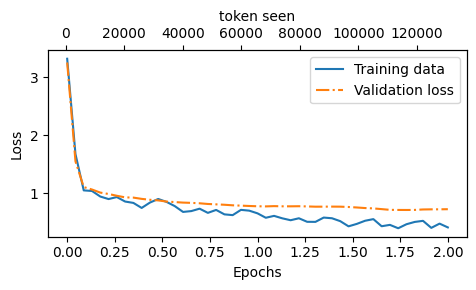

In [32]:
from LLMcore import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [33]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(model, idx=text_to_token_ids(input_text, tokenizer).to(device), max_new_tokens=256, context_size=BASE_CONFIG['context_length'], eos_id=50256)

    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (generated_text[len(input_text):].replace("### Response:", "").strip())

    print(input_text)
    print(f"\nCorrect Response : \n>>{entry['output']}")
    print(f"\nModel Response :\n>> {response_text.strip()}")
    print("--------------------------------------------------------")

Below is an instruction that describes a task. Write a respone that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct Response : 
>>The car is as fast as lightning.

Model Response :
>> The car is as fast as a horse.
--------------------------------------------------------
Below is an instruction that describes a task. Write a respone that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct Response : 
>>The type of cloud typically associated with thunderstorms is cumulonimbus.

Model Response :
>> A type of cloud typically associated with thunderstorms is a dense, dense, dense, dense, dense, dense, dense.
--------------------------------------------------------
Below is an instruction that describes a task. Write a respone that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Cor

In [34]:
from tqdm import tqdm
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [05:09<00:00,  2.81s/it]


In [35]:
file_name = "gpt2-medium355M-sft.pth"
torch.save(model.state_dict(), file_name)
print("Model saved as : ", file_name)

Model saved as :  gpt2-medium355M-sft.pth


In [37]:
!pip install dotenv-python

  Preparing metadata (setup.py) ... done
  Created wheel for dotenv-python: filename=dotenv_python-0.0.1-py3-none-any.whl size=2072 sha256=44af7c11d1d5323786dda23c124c1b7d4db946415c4f3b284a99108ddbfbfa04
  Stored in directory: /home/zeus/.cache/pip/wheels/d8/1d/34/3a277b010648f6b1ad1cd503116d00a407a2c34c7aacf3a3ed
Successfully built dotenv-python

[notice] A new release of pip is available: 24.1.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [38]:
from dotenv import load_dotenv, dotenv_values
import os
load_dotenv(override=True)

False

In [39]:
import json 
from tqdm import tqdm

file_path = "instruction-data-with-response.json"
with open(file_path, "r") as file:
    test_data = json.load(file)

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # print(entry['output'])
    # print(entry['model_response'])


    input_text = (f"\n\n### Input :\n{entry['input']}" if entry["input"] else "") 
    return instruction_text + input_text

In [41]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 27.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.1.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [43]:
import os
from dotenv import load_dotenv
from openai import OpenAI

# Load environment variables from the .env file
load_dotenv()

# Initialize OpenAI client with the API key from environment variables
client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)
model = "gpt-3.5-turbo"
def get_query(prompt , model):

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=model,
        # response_format={"type" : "json_object"}

    )

    return chat_completion.choices[0].message.content

In [44]:
for entry in test_data[:2]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" one a scale from 0 to 100, where 100 is the best score, and answer only the score. example if score is 66 answer only 66."
    )

    print('Dataset Response : ')
    print(">>", entry['output'])
    print('\nModel response : ')
    print(">>", entry['model_response'])
    print("\nScore : ")
    response = get_query(prompt, model)
    print(">>", int(response))
    print("\n------------------------")

Dataset Response : 
>> The car is as fast as lightning.

Model response : 
>> The car is as fast as a horse.

Score : 
>> 80

------------------------
Dataset Response : 
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response : 
>> A type of cloud typically associated with thunderstorms is a dense, dense, dense, dense, dense, dense, dense.

Score : 
>> 10

------------------------


In [45]:
def generate_model_scores(json_data, model):
    scores = []
    for entry in tqdm(json_data, desc='scoring enteries'):
        prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`" # key = model_resposne
        f" one a scale from 0 to 100, where 100 is the best score, and answer only the score. example if score is 66 answer only 66."
        )

        score = get_query(prompt , model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"could not convert score: {score}")
    
    return scores

In [47]:
model =  "gpt-3.5-turbo"
scores = generate_model_scores(test_data, model)
print(f"Number of scores : {len(scores)} of {len(test_data)}")
print(f"Average score on {model} : {sum(scores)/len(scores):.2f}\n")

scoring enteries: 100%|██████████| 110/110 [00:34<00:00,  3.16it/s]

Number of scores : 110 of 110
Average score on gpt-3.5-turbo : 45.84



In [48]:
print(f"Average score : {sum(scores)/len(scores):.2f}\n")

Average score : 45.84

